# Linear models (LiNGAM)

## Introduction

If we are willing to make assumptions about the **functional form** of the structural causal model or the **distribution of the errors**, we can go beyond the Markov equivalence class and identify the complete causal structure of the data-generating process. In this first chapter of semi-parametric models, we introduce the **linear non-Gaussian acyclic model (LiNGAM)** {cite}`shimizu2006linear`.

## The LiNGAM model

The LiNGAM model for $p$ observed variables $x_1, x_2, \ldots, x_p$ is given by

\begin{equation}
    x_i = \sum_{j \in \operatorname{pa}(x_i)}b_{ij}x_j + e_i \quad (i=1, \ldots, p)
\end{equation}

where each observed variable $x_i$ is a linear sum of their parent variables $\operatorname{pa}(x_i)$ plus some noise $e_i$. If the coefficient $b_{ij}$ is zero, then there is no direct causal effect from $x_j$ to $x_i$. The error variables $e_i$ are **independent** and follow continuous **non-Gaussian** distributions. The independence means there are **no unobserved or hidden common causes**.

In matrix notation, the model is given by

\begin{equation}
    \mathbf{x} = \mathbf{B}\mathbf{x} + \mathbf{e}
\end{equation}

where $\mathbf{x}$ and $\mathbf{e}$ are $p$-dimensional vectors, and $\mathbf{B}$ is a $p\times p$ matrix that contains the $b_{ij}$ coefficients, with $i, j=1, \ldots, p$.

Let us consider a simple **example** with three variables:
- **Electricity prices** are directly influences by wind generation.
- **Carbon emissions** are influenced by electricity prices, assuming that changes in pricing can affect energy consumption patterns and emissions.
- **Wind generation** is influenced by external factors and serves as an exogenous variable in this model.


### Strucural equations
If we know the coefficients of those causal relations, the SCM can be written as

\begin{align}
\text{electricity prices} &= -1 \times \text{wind generation} + e_p \\
\text{carbon emissions} &= -1.5 \times \text{Electricity Prices} + e_c \\
\text{wind generation} &= e_w \\
\end{align}



### Matrix notation
Then, in matrix notation, this model is given by

\begin{equation}
    \left[\begin{array}{c} 
    \text{electricity prices} \\
    \text{carbon emissions} \\
    \text{wind generation}
    \end{array}\right]
    =
    \left[\begin{array}{ccc}
    0 & 0 & -1 \\
    -1.5 & 0 & 0 \\
    0 & 0 & 0
    \end{array}\right]
    \left[\begin{array}{c} 
    \text{electricity prices} \\
    \text{carbon emissions} \\
    \text{wind generation}
    \end{array}\right]
    +
    \left[\begin{array}{c}
    e_p \\
    e_c \\
    e_w
    \end{array}\right]
\end{equation}


### Causal ordering
Typically, we **order** the the structural equations according to the **true causal order**, so that the matrix $\mathbf{B}$ is permuted to be a **lower triangular matrix** (this property is used later on to identify the true structure), with all the diagonal elements equal to zero (strictly lower triangular). This simply means that we rewrite the structural equations as

\begin{align}
\text{wind generation} &= e_w \\
\text{electricity prices} &= -1 \times \text{wind generation} + e_p \\
\text{carbon emissions} &= -1.5 \times \text{Electricity Prices} + e_c \\
\end{align}

that, in matrix notation, becomes

\begin{equation}
    \left[\begin{array}{c} 
    \text{wind generation} \\
    \text{electricity prices} \\
    \text{carbon emissions}
    \end{array}\right]
    =
    \left[\begin{array}{ccc}
    0 & 0 & 0 \\
    -1 & 0 & 0 \\
    0 & -1.5 & 0
    \end{array}\right]
    \left[\begin{array}{c} 
    \text{wind generation} \\
    \text{electricity prices} \\
    \text{carbon emissions}
    \end{array}\right]
    +
    \left[\begin{array}{c}
    e_w \\
    e_p \\
    e_c
    \end{array}\right]
\end{equation}

Now, we can rewrite the LiNGAM model as

\begin{equation}
    x_i = \sum_{j:k(j)<k(i)}b_{ij}x_j + e_i \quad (i=1, \ldots, p)
\end{equation}


where $k(\cdot)$ represents the causal ordering, meaning that each variable $x_i$ is a linear sum of the $x_j$ variables observed earlier in the causal graph ($k(j)<k(i)$), plus its own error variable $e_i$. We can now plot the **causal graph**, using the LiNGAM library.

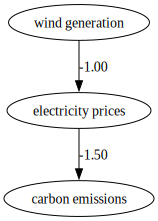

In [1]:
import numpy as np
from lingam.utils import make_dot

# Matrix of coefficients (weights)
B = np.array([[0.0, 0.0, 0.0],
              [-1.0, 0.0, 0.0],
              [0.0, -1.5, 0.0]])

# Plotting causal graph
make_dot(B, labels=["wind generation", "electricity prices", "carbon emissions"])

## Estimation methods

Now that we explained the basic formulation, we explain how to **estimate the model from the data**. There are two main approaches to estimate a LiNGAM model: a direct estimation method (**DirectLiNGAM**) through a series of regressions and independence tests, and a method based on independent component analysis (ICA) (**ICA-based LinGAM**). In the case of linear models, the key assumption is that the **errors are non-Gaussians**. This is the most important assumption as it allows us to identify the causal structure, both using DirectLiNGAM and ICA-based LiNGAM.

### DirectLiNGAM
DirectLiNGAM is an iterative procedure that employs a series of regressions and independence tests to directly identify the causal order among the observed variables. It leverages the non-Gaussianity of the data and the assumption of linear causality to systematically test for independence between variables and their residuals from regressions. 

The key intuition is that, with non-Gaussian errors, the **residuals in the anti-causal direction** will not be independent of the predictor. We will see how this works with a practical example.

#### Example with Gaussian errors
Let us consider a simple example, like the one we saw above, but for simplicity we only keep two variables.

\begin{align}
\text{wind generation} &= e_w \\
\text{electricity prices} &= -1 \times \text{wind generation} + e_p \\
\end{align}

We now assume Gaussian errors, so we have that $e_w, e_p  \sim \mathcal{N}(0, 1)$.

We will show that, in this case, by analysing the residuals we cannot understand the true causal direction, because we can both predict the wind from the prices and the prices from the wind.

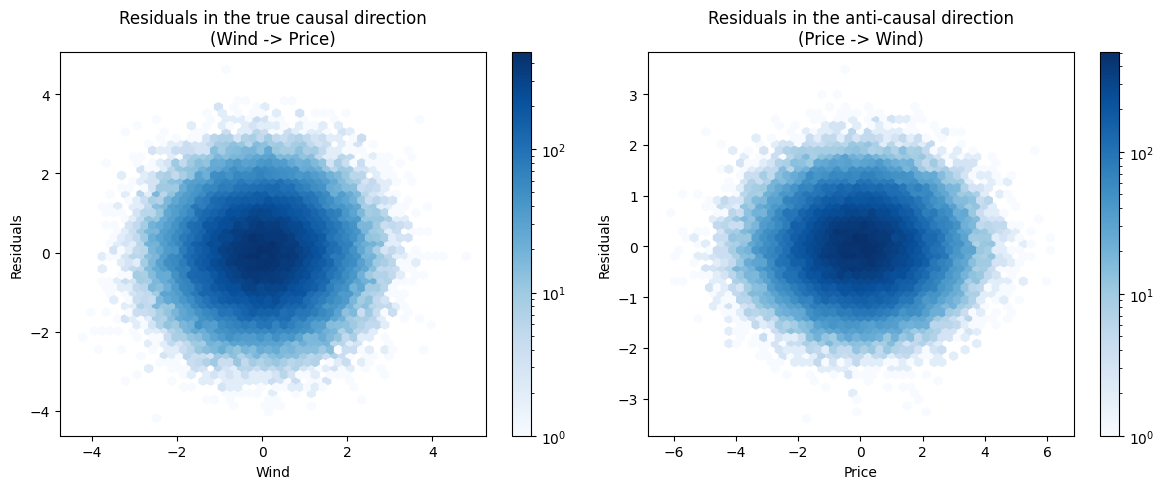

In [2]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Synthetic data generation based on the given equations
n = 100000
wind = np.random.normal(0, 1, size=n)  # Predictor variable
price = -1 * wind + np.random.normal(0, 1, size=n)  # Response variable with non-Gaussian noise (uniform)

# Prepare the data for regression
wind_with_const = sm.add_constant(wind)  # Add a constant term for the intercept
price_with_const = sm.add_constant(price)  # Add a constant term for the intercept

# Linear regression in the true causal direction (wind -> price)
true_model = sm.OLS(endog=price, exog=wind_with_const)
true_model_results = true_model.fit()
price_pred = true_model_results.predict(wind_with_const)
price_residuals = price - price_pred

# Linear regression in the anti-causal direction (price -> wind)
anti_model = sm.OLS(endog=wind, exog=price_with_const)
anti_model_results = anti_model.fit()
wind_pred = anti_model_results.predict(price_with_const)
wind_residuals = wind - wind_pred

# Setting up the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# All the data
hb1 = axes[0].hexbin(wind, price_residuals, gridsize=50, cmap='Blues', bins='log')
cb1 = fig.colorbar(hb1, ax=axes[0])
axes[0].set_title('Residuals in the true causal direction\n(Wind -> Price)')
axes[0].set_xlabel('Wind')
axes[0].set_ylabel('Residuals')

# After conditioning
hb2 = axes[1].hexbin(price, wind_residuals, gridsize=50, cmap='Blues', bins='log')
cb2 = fig.colorbar(hb2, ax=axes[1])
axes[1].set_title('Residuals in the anti-causal direction\n(Price -> Wind)')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Residuals')

plt.tight_layout()

Where we can see how the residuals are independent of the input variable in both the true and anti-causal directions.


#### Example with non-Gaussian errors

Now, by simply assuming the errors are uniformly distributed, we can wee how it will be possible to detect the true causal direction by testing the independence of the residuals from the input variable.

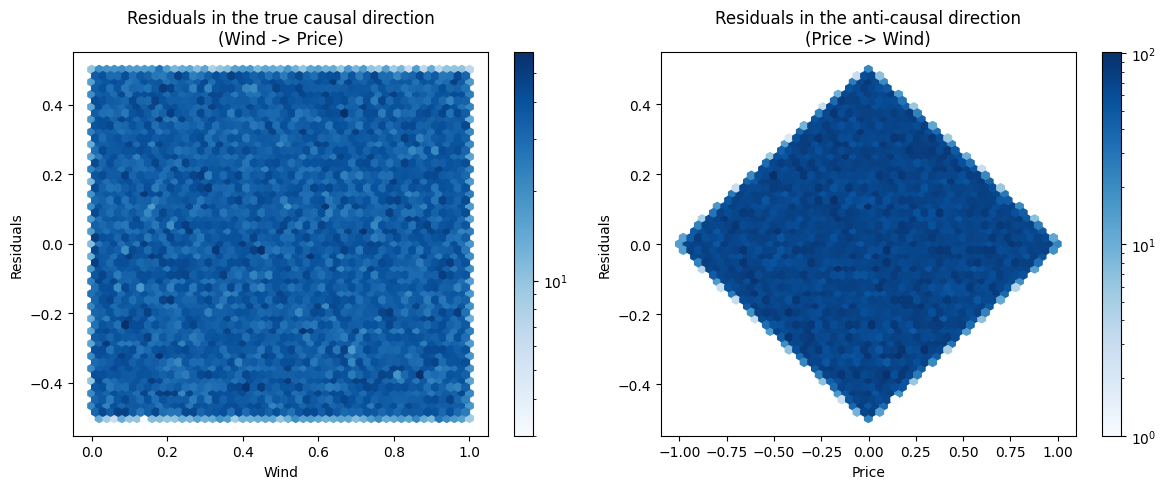

In [3]:
# Synthetic data generation based on the given equations
wind = np.random.uniform(0, 1, size=n)  # Predictor variable
price = -1 * wind + np.random.uniform(0, 1, size=n)  # Response variable with non-Gaussian noise (uniform)

# Prepare the data for regression
wind_with_const = sm.add_constant(wind)  # Add a constant term for the intercept
price_with_const = sm.add_constant(price)  # Add a constant term for the intercept

# Linear regression in the true causal direction (wind -> price)
true_model = sm.OLS(endog=price, exog=wind_with_const)
true_model_results = true_model.fit()
price_pred = true_model_results.predict(wind_with_const)
price_residuals = price - price_pred

# Linear regression in the anti-causal direction (price -> wind)
anti_model = sm.OLS(endog=wind, exog=price_with_const)
anti_model_results = anti_model.fit()
wind_pred = anti_model_results.predict(price_with_const)
wind_residuals = wind - wind_pred

# Setting up the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# All the data
hb1 = axes[0].hexbin(wind, price_residuals, gridsize=50, cmap='Blues', bins='log')
cb1 = fig.colorbar(hb1, ax=axes[0])
axes[0].set_title('Residuals in the true causal direction\n(Wind -> Price)')
axes[0].set_xlabel('Wind')
axes[0].set_ylabel('Residuals')

# After conditioning
hb2 = axes[1].hexbin(price, wind_residuals, gridsize=50, cmap='Blues', bins='log')
cb2 = fig.colorbar(hb2, ax=axes[1])
axes[1].set_title('Residuals in the anti-causal direction\n(Price -> Wind)')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Residuals')

plt.tight_layout()

### ICA-based LiNGAM

ICA is a computational method, developed in the field of signal processing, to separate a multivariate signal into additive subcomponents assuming that these subcomponents are non-Gaussian signals and statistically independent from each other. Consider a simple ICA model given by

\begin{align}
    x_1 &= a_{11}s_1 + a_{12}s_2 \\
    x_2 &= a_{21}s_1 + a_{22}s_2
\end{align}

where $x_1$ and $x_2$ are the observed variables, and $s_1$ and $s_2$ are continuous hidden variables. Assuming that $s_1$ and $s_2$ are **independent** and **non-Gaussian**, ICA attempts to recover them from the observed matrix $\mathbf{X}$. In matrix form, we can write it as

\begin{equation}
    \mathbf{x} = \mathbf{A}\mathbf{s}
\end{equation}

In our example, it would mean

\begin{equation}
    \left[\begin{array}{c} 
    x_1 \\ x_2
    \end{array}\right]
    =\left[\begin{array}{cc}
    a_{11} & a_{12} \\
    a_{21} & a_{22}
    \end{array}\right]
    \left[\begin{array}{c}
    s_1 \\
    s_2
    \end{array}\right]
\end{equation}

The $p \times q$ mixing matrix $\mathbf{A}$ represents how the unobserved components $\mathbf{s}$ are mixed to generate the observed variables $\mathbf{x}$. Any two columns of $\mathbf{A}$ are assumed to be linearly independent. The mixing matrix $\mathbf{A}$ is identifiable, except for the **ordering** and **scaling** of its columns. 

In [4]:
ica = FastICA(n_components=2)
recovered_signals = ica.fit_transform(X)  # Reconstruct signals
plt.figure(figsize=(12, 4))
plt.plot(time, recovered_signals)

NameError: name 'FastICA' is not defined

In [1]:
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We start by generating the original signals $s_1$ and $s_2$

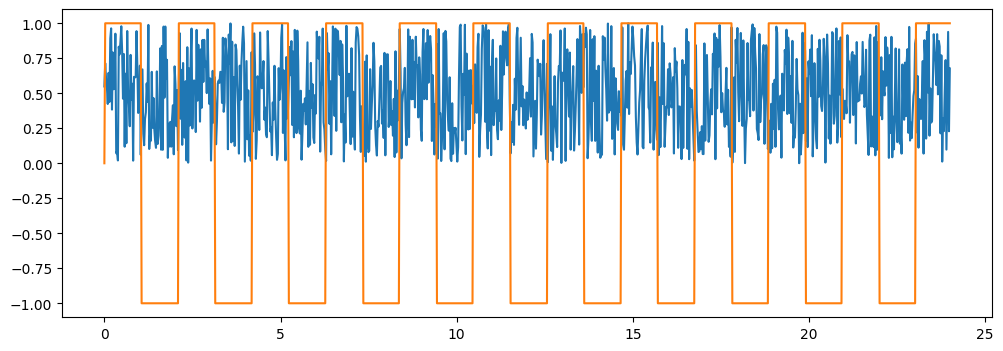

In [2]:
np.random.seed(0)
sample_size = 1000
time = np.linspace(0, 24, sample_size)
s1 = np.random.uniform(low=0, high=1, size=sample_size)
s2 = np.sign(np.sin(3 * time))  # Signal 2: square signal
S = np.c_[s1, s2]
plt.figure(figsize=(12, 4))
plt.plot(time, S)

We now mix the signals, to generate the observed matrix $\mathbf{X}$ 

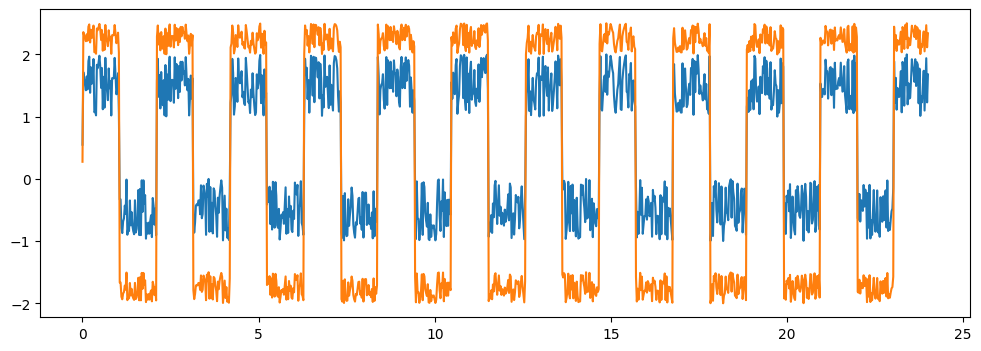

In [3]:
# Mix data
A = np.array([[1, 1], [0.5, 2]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations
plt.figure(figsize=(12, 4))
plt.plot(time, X)

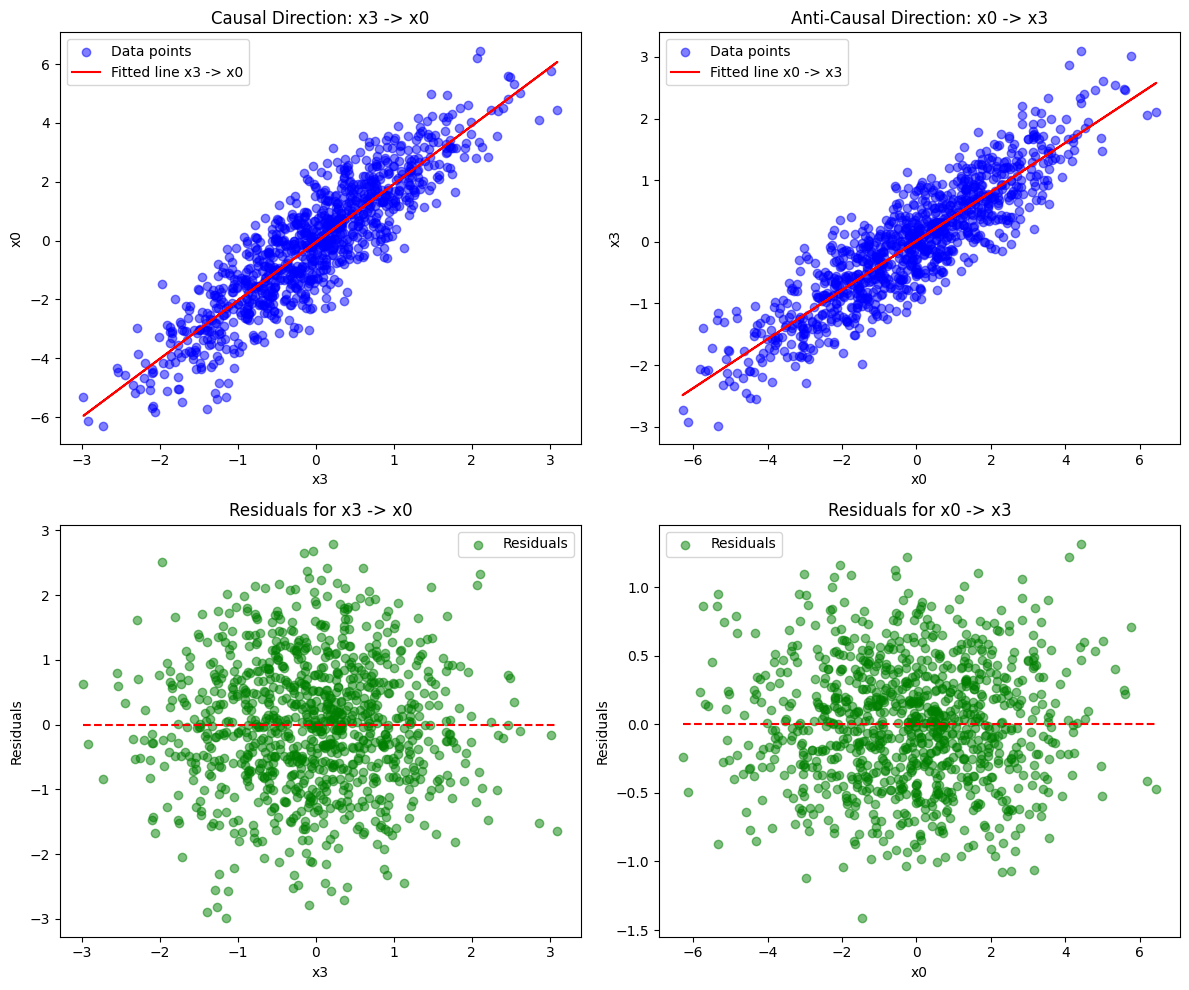

### DirectLiNGAM

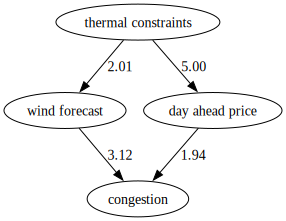

In [12]:
direct_model = lingam.DirectLiNGAM()
direct_model.fit(X)
direct_model.causal_order_
direct_model.adjacency_matrix_
make_dot(direct_model.adjacency_matrix_, labels=["wind forecast", "congestion", "day ahead price", "thermal constraints"])

### ICA-based LiNGAM

In matrix notation, the model is given by

\begin{equation}
    \mathbf{x} = \mathbf{B}\mathbf{x} + \mathbf{e}
\end{equation}

where $\mathbf{x}$ and $\mathbf{e}$ are $p$-dimensional vectors, and $\mathbf{B}$ is a $p\times p$ matrix that contains the $b_{ij}$ coefficients, with $i, j=1, \ldots, p$. We can solve the equation $\mathbf{x} = \mathbf{B}\mathbf{x} + \mathbf{e}$ for the vector of observed variables $\mathbf{x}$ as in

\begin{equation}
    (\mathbf{I}- \mathbf{B})\mathbf{x} = \mathbf{e}
\end{equation}

Then, if we left-multiply both sides by the inverse of $\mathbf{I}- \mathbf{B}$, we get

\begin{align}
    (\mathbf{I}- \mathbf{B})^{-1}(\mathbf{I}- \mathbf{B})\mathbf{x} &= (\mathbf{I}- \mathbf{B})^{-1}\mathbf{e} \\
    \mathbf{x} &= (\mathbf{I}- \mathbf{B})^{-1}\mathbf{e} \\
    \mathbf{x} &= \mathbf{A}\mathbf{e} \label{eq:lingam-ica}
\end{align}

Now, since we assumed the errors are independent and non-Gaussian, we have that this equation corresponds to the ICA model, and the matrix $\mathbf{A} = (\mathbf{I}- \mathbf{B})^{-1}$ corresponds to the mixing matrix in ICA. This gives the hint of why we can use ICA to estimate the LiNGAM model. The cool part is that, in this case, using the **acyclicity assumption**, we can also find the coefficients in terms of the right **ordering** and **scaling**.

Let's start by generating data from a known causal structure.

In [5]:
import pandas as pd
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot
from lingam.utils import make_dot

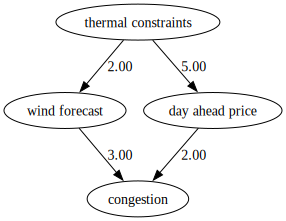

In [6]:
# Linear structural equations with non-Gaussian noise
sample_size = 1000
x3 = np.random.uniform(low=0, high=1, size=sample_size)
x0 = 2.0*x3 + np.random.uniform(low=0, high=1, size=sample_size)
x2 = 5.0*x3 + np.random.beta(a=2, b=8, size=sample_size)
x1 = 3.0*x0 + 2.0*x2 + np.random.exponential(scale=1, size=sample_size)
X = pd.DataFrame(np.array([x0, x1, x2, x3]).T, columns=['x0', 'x1', 'x2', 'x3'])

# Matrix of coefficients
m = np.array([[0.0, 0.0, 0.0, 2.0],
              [3.0, 0.0, 2.0, 0.0],
              [0.0, 0.0, 0.0, 5.0],
              [0.0, 0.0, 0.0, 0.0]])

# Saving graph
make_dot(m, labels=["wind forecast", "congestion", "day ahead price", "thermal constraints"])
        #, path=(3, 1), path_color="red")

We can now apply ICA to retrieve the independent components

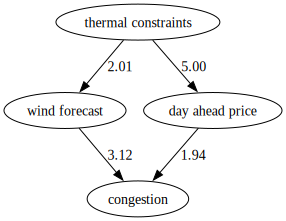

In [11]:
# ICA-based LiNGAM
ica_model = lingam.ICALiNGAM()
ica_model.fit(X)
ica_model.causal_order_
ica_model.adjacency_matrix_
make_dot(ica_model.adjacency_matrix_, labels=["wind forecast", "congestion", "day ahead price", "thermal constraints"])